<a href="https://colab.research.google.com/github/jimenasalinas/RedditGoesGreen/blob/main/models/Word2Vec_final_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from google.colab import drive
from datasets import Dataset
import random
import csv
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score

In [3]:
drive.mount('/content/drive')

# Load data
data_path = "/content/drive/My Drive/group_project/archive/"

Mounted at /content/drive


In [ ]:
# !pip install datasets

In [4]:
# Threshold data
dtype_dict = {'label': int}
comments = pd.read_csv(data_path + "comments_filtered_by_categories.csv", quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

Futurology

In [5]:
# Split the data into features and target label
X = comments[comments["subreddit.name"]=='futurology'].drop('label', axis=1)  # Features (all columns except 'label')
y = comments[comments["subreddit.name"]=='futurology']['label']  # Target label

# Splitting the dataset into training and testing sets with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=120938)


In [6]:
# Number of observations for the smaller datasets
train_obs = 15000
test_obs = 1500

# Training set
# Shuffling DataFrame
X_train_shuffled = X_train.sample(n=len(X_train), random_state=42).reset_index(drop=True)
y_train_shuffled = y_train.sample(n=len(y_train), random_state=42).reset_index(drop=True)
# Selecting the first 'train_obs' samples
small_X_train = X_train_shuffled.head(train_obs)
small_y_train = y_train_shuffled.head(train_obs)

# Testing set
# Shuffling DataFrame
X_test_shuffled = X_test.sample(n=len(X_test), random_state=42).reset_index(drop=True)
y_test_shuffled = y_test.sample(n=len(y_test), random_state=42).reset_index(drop=True)
# Selecting the first 'test_obs' samples
small_X_test = X_test_shuffled.head(test_obs)
small_y_test = y_test_shuffled.head(test_obs)

In [ ]:
# Preprocessing
# nltk.download('stopwords')
# stop_words = stopwords.words('english')

# Function to remove stopwords
def remove_stopwords(transcript):
    words = transcript.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def clean_transcript(df):
    df['clean_transcript'] = df['body'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    df['clean_transcript'] = df['clean_transcript'].astype(str).apply(remove_stopwords)
    df.dropna(subset=['clean_transcript'], inplace=True)
    return df

# Apply cleaning and stopword removal to your dataset
small_X_train = clean_transcript(small_X_train)
small_X_test = clean_transcript(small_X_test)

# Tokenize the cleaned transcripts
small_X_train['tokenized'] = small_X_train['clean_transcript'].apply(lambda x: x.split())
small_X_test['tokenized'] = small_X_test['clean_transcript'].apply(lambda x: x.split())

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=small_X_train['tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Generate a feature vector for each document
def comment_vector(comment):
    # remove out-of-vocabulary words
    comment = [word for word in comment if word in model.wv.index_to_key]
    if not comment:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[comment], axis=0)

small_X_train['doc_vector'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector'] = small_X_test['tokenized'].apply(comment_vector)

In [9]:
X_train_vectors = np.stack(small_X_train['doc_vector'].values)
X_test_vectors = np.stack(small_X_test['doc_vector'].values)

In [11]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))


Logistic Regression Accuracy: 0.636
F1 Score: 0.6374501992031874


**Pretrained model**

In [ ]:
# # Path to the Google News Word2Vec model
# corpus_path = data_path + "GoogleNews-vectors-negative300.bin.gz"

# # Load the pre-trained Word2Vec model
model_pretrained = KeyedVectors.load_word2vec_format(corpus_path, binary=True)

# Generate a feature vector for each document
def comment_vector(comment):
    # Remove out-of-vocabulary words
    comment = [word for word in comment if word in model_pretrained.key_to_index]
    if not comment:
        return np.zeros(model_pretrained.vector_size)
    # Use model_pretrained directly to get word vectors
    return np.mean([model_pretrained[word] for word in comment], axis=0)

small_X_train['doc_vector_pretrained'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector_pretrained'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors_pretrained = np.stack(small_X_train['doc_vector_pretrained'].values)
X_test_vectors_pretrained = np.stack(small_X_test['doc_vector_pretrained'].values)

In [13]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors_pretrained, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors_pretrained)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.7406666666666667
F1 Score: 0.7455853499018967


Australia

In [37]:
# Split the data into features and target label
X = comments[comments["subreddit.name"]=='australia'].drop('label', axis=1)  # Features (all columns except 'label')
y = comments[comments["subreddit.name"]=='australia']['label']  # Target label

# Splitting the dataset into training and testing sets with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=120938)

In [38]:
# Number of observations for the smaller datasets
train_obs = 15000
test_obs = 1500

# Training set
# Shuffling DataFrame
X_train_shuffled = X_train.sample(n=len(X_train), random_state=42).reset_index(drop=True)
y_train_shuffled = y_train.sample(n=len(y_train), random_state=42).reset_index(drop=True)
# Selecting the first 'train_obs' samples
small_X_train = X_train_shuffled.head(train_obs)
small_y_train = y_train_shuffled.head(train_obs)

# Testing set
# Shuffling DataFrame
X_test_shuffled = X_test.sample(n=len(X_test), random_state=42).reset_index(drop=True)
y_test_shuffled = y_test.sample(n=len(y_test), random_state=42).reset_index(drop=True)
# Selecting the first 'test_obs' samples
small_X_test = X_test_shuffled.head(test_obs)
small_y_test = y_test_shuffled.head(test_obs)

In [ ]:
# Apply cleaning and stopword removal to your dataset
small_X_train = clean_transcript(small_X_train)
small_X_test = clean_transcript(small_X_test)

# Tokenize the cleaned transcripts
small_X_train['tokenized'] = small_X_train['clean_transcript'].apply(lambda x: x.split())
small_X_test['tokenized'] = small_X_test['clean_transcript'].apply(lambda x: x.split())

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=small_X_train['tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Generate a feature vector for each document
def comment_vector(comment):
    # remove out-of-vocabulary words
    comment = [word for word in comment if word in model.wv.index_to_key]
    if not comment:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[comment], axis=0)

small_X_train['doc_vector'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors = np.stack(small_X_train['doc_vector'].values)
X_test_vectors = np.stack(small_X_test['doc_vector'].values)

In [41]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.6546666666666666
F1 Score: 0.6093514328808446


Pretrained australia

In [ ]:
# Generate a feature vector for each document
def comment_vector(comment):
    # Remove out-of-vocabulary words
    comment = [word for word in comment if word in model_pretrained.key_to_index]
    if not comment:
        return np.zeros(model_pretrained.vector_size)
    # Use model_pretrained directly to get word vectors
    return np.mean([model_pretrained[word] for word in comment], axis=0)

small_X_train['doc_vector_pretrained'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector_pretrained'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors_pretrained = np.stack(small_X_train['doc_vector_pretrained'].values)
X_test_vectors_pretrained = np.stack(small_X_test['doc_vector_pretrained'].values)

In [45]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors_pretrained, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors_pretrained)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.7673333333333333
F1 Score: 0.7523066004258339


Canada

In [52]:
# Split the data into features and target label
X = comments[comments["subreddit.name"]=='canada'].drop('label', axis=1)  # Features (all columns except 'label')
y = comments[comments["subreddit.name"]=='canada']['label']  # Target label

# Splitting the dataset into training and testing sets with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=120938)

In [53]:
# Number of observations for the smaller datasets
train_obs = 15000
test_obs = 1500

# Training set
# Shuffling DataFrame
X_train_shuffled = X_train.sample(n=len(X_train), random_state=42).reset_index(drop=True)
y_train_shuffled = y_train.sample(n=len(y_train), random_state=42).reset_index(drop=True)
# Selecting the first 'train_obs' samples
small_X_train = X_train_shuffled.head(train_obs)
small_y_train = y_train_shuffled.head(train_obs)

# Testing set
# Shuffling DataFrame
X_test_shuffled = X_test.sample(n=len(X_test), random_state=42).reset_index(drop=True)
y_test_shuffled = y_test.sample(n=len(y_test), random_state=42).reset_index(drop=True)
# Selecting the first 'test_obs' samples
small_X_test = X_test_shuffled.head(test_obs)
small_y_test = y_test_shuffled.head(test_obs)

In [ ]:
# Apply cleaning and stopword removal to your dataset
small_X_train = clean_transcript(small_X_train)
small_X_test = clean_transcript(small_X_test)

# Tokenize the cleaned transcripts
small_X_train['tokenized'] = small_X_train['clean_transcript'].apply(lambda x: x.split())
small_X_test['tokenized'] = small_X_test['clean_transcript'].apply(lambda x: x.split())

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=small_X_train['tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Generate a feature vector for each document
def comment_vector(comment):
    # remove out-of-vocabulary words
    comment = [word for word in comment if word in model.wv.index_to_key]
    if not comment:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[comment], axis=0)

small_X_train['doc_vector'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors = np.stack(small_X_train['doc_vector'].values)
X_test_vectors = np.stack(small_X_test['doc_vector'].values)

In [56]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.6126666666666667
F1 Score: 0.6415792720542874


Pretrained Canada

In [ ]:
# Generate a feature vector for each document
def comment_vector(comment):
    # Remove out-of-vocabulary words
    comment = [word for word in comment if word in model_pretrained.key_to_index]
    if not comment:
        return np.zeros(model_pretrained.vector_size)
    # Use model_pretrained directly to get word vectors
    return np.mean([model_pretrained[word] for word in comment], axis=0)

small_X_train['doc_vector_pretrained'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector_pretrained'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors_pretrained = np.stack(small_X_train['doc_vector_pretrained'].values)
X_test_vectors_pretrained = np.stack(small_X_test['doc_vector_pretrained'].values)

In [58]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors_pretrained, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors_pretrained)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.736
F1 Score: 0.7408376963350785


Collapse

In [59]:
# Split the data into features and target label
X = comments[comments["subreddit.name"]=='collapse'].drop('label', axis=1)  # Features (all columns except 'label')
y = comments[comments["subreddit.name"]=='collapse']['label']  # Target label

# Splitting the dataset into training and testing sets with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=120938)

In [60]:
# Number of observations for the smaller datasets
train_obs = 15000
test_obs = 1500

# Training set
# Shuffling DataFrame
X_train_shuffled = X_train.sample(n=len(X_train), random_state=42).reset_index(drop=True)
y_train_shuffled = y_train.sample(n=len(y_train), random_state=42).reset_index(drop=True)
# Selecting the first 'train_obs' samples
small_X_train = X_train_shuffled.head(train_obs)
small_y_train = y_train_shuffled.head(train_obs)

# Testing set
# Shuffling DataFrame
X_test_shuffled = X_test.sample(n=len(X_test), random_state=42).reset_index(drop=True)
y_test_shuffled = y_test.sample(n=len(y_test), random_state=42).reset_index(drop=True)
# Selecting the first 'test_obs' samples
small_X_test = X_test_shuffled.head(test_obs)
small_y_test = y_test_shuffled.head(test_obs)

In [ ]:
# Apply cleaning and stopword removal to your dataset
small_X_train = clean_transcript(small_X_train)
small_X_test = clean_transcript(small_X_test)

# Tokenize the cleaned transcripts
small_X_train['tokenized'] = small_X_train['clean_transcript'].apply(lambda x: x.split())
small_X_test['tokenized'] = small_X_test['clean_transcript'].apply(lambda x: x.split())

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=small_X_train['tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Generate a feature vector for each document
def comment_vector(comment):
    # remove out-of-vocabulary words
    comment = [word for word in comment if word in model.wv.index_to_key]
    if not comment:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[comment], axis=0)

small_X_train['doc_vector'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors = np.stack(small_X_train['doc_vector'].values)
X_test_vectors = np.stack(small_X_test['doc_vector'].values)

In [63]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.6586666666666666
F1 Score: 0.5151515151515151


Pretrained collapse

In [ ]:
# Generate a feature vector for each document
def comment_vector(comment):
    # Remove out-of-vocabulary words
    comment = [word for word in comment if word in model_pretrained.key_to_index]
    if not comment:
        return np.zeros(model_pretrained.vector_size)
    # Use model_pretrained directly to get word vectors
    return np.mean([model_pretrained[word] for word in comment], axis=0)

small_X_train['doc_vector_pretrained'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector_pretrained'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors_pretrained = np.stack(small_X_train['doc_vector_pretrained'].values)
X_test_vectors_pretrained = np.stack(small_X_test['doc_vector_pretrained'].values)

In [65]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors_pretrained, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors_pretrained)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.7426666666666667
F1 Score: 0.67008547008547


the_donald

In [66]:
# Split the data into features and target label
X = comments[comments["subreddit.name"]=='the_donald'].drop('label', axis=1)  # Features (all columns except 'label')
y = comments[comments["subreddit.name"]=='the_donald']['label']  # Target label

# Splitting the dataset into training and testing sets with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=120938)

In [67]:
# Number of observations for the smaller datasets
train_obs = 15000
test_obs = 1500

# Training set
# Shuffling DataFrame
X_train_shuffled = X_train.sample(n=len(X_train), random_state=42).reset_index(drop=True)
y_train_shuffled = y_train.sample(n=len(y_train), random_state=42).reset_index(drop=True)
# Selecting the first 'train_obs' samples
small_X_train = X_train_shuffled.head(train_obs)
small_y_train = y_train_shuffled.head(train_obs)

# Testing set
# Shuffling DataFrame
X_test_shuffled = X_test.sample(n=len(X_test), random_state=42).reset_index(drop=True)
y_test_shuffled = y_test.sample(n=len(y_test), random_state=42).reset_index(drop=True)
# Selecting the first 'test_obs' samples
small_X_test = X_test_shuffled.head(test_obs)
small_y_test = y_test_shuffled.head(test_obs)

In [ ]:
# Apply cleaning and stopword removal to your dataset
small_X_train = clean_transcript(small_X_train)
small_X_test = clean_transcript(small_X_test)

# Tokenize the cleaned transcripts
small_X_train['tokenized'] = small_X_train['clean_transcript'].apply(lambda x: x.split())
small_X_test['tokenized'] = small_X_test['clean_transcript'].apply(lambda x: x.split())

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=small_X_train['tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Generate a feature vector for each document
def comment_vector(comment):
    # remove out-of-vocabulary words
    comment = [word for word in comment if word in model.wv.index_to_key]
    if not comment:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[comment], axis=0)

small_X_train['doc_vector'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors = np.stack(small_X_train['doc_vector'].values)
X_test_vectors = np.stack(small_X_test['doc_vector'].values)

In [70]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.6406666666666667
F1 Score: 0.5907365223993926


Pretrained the_donald

In [ ]:
# Generate a feature vector for each document
def comment_vector(comment):
    # Remove out-of-vocabulary words
    comment = [word for word in comment if word in model_pretrained.key_to_index]
    if not comment:
        return np.zeros(model_pretrained.vector_size)
    # Use model_pretrained directly to get word vectors
    return np.mean([model_pretrained[word] for word in comment], axis=0)

small_X_train['doc_vector_pretrained'] = small_X_train['tokenized'].apply(comment_vector)
small_X_test['doc_vector_pretrained'] = small_X_test['tokenized'].apply(comment_vector)

X_train_vectors_pretrained = np.stack(small_X_train['doc_vector_pretrained'].values)
X_test_vectors_pretrained = np.stack(small_X_test['doc_vector_pretrained'].values)

In [72]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_vectors_pretrained, small_y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test_vectors_pretrained)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(small_y_test, lr_predictions))
print("F1 Score:", f1_score(small_y_test, lr_predictions))

Logistic Regression Accuracy: 0.76
F1 Score: 0.7428571428571429


Graph

In [74]:
import pandas as pd

# Manually creating the DataFrame from the provided data
data = {
    'Subreddit': ['threshold', 'australia', 'canada', 'collapse', 'futurology', 'the_donald'],
    'Selftrained Accuracy': [0.621333333, 0.654666667, 0.612666667, 0.658666667, 0.636, 0.640666667],
    'Pretrained Accuracy': [0.727333333, 0.767333333, 0.736, 0.742666667, 0.740666667, 0.76],
    'Selftrained F1': [0.597733711, 0.609351433, 0.641579272, 0.515151515, 0.637450199, 0.590736522],
    'Pretrained F1': [0.718125431, 0.7523066, 0.740837696, 0.67008547, 0.74558535, 0.742857143]
}

df = pd.DataFrame(data)

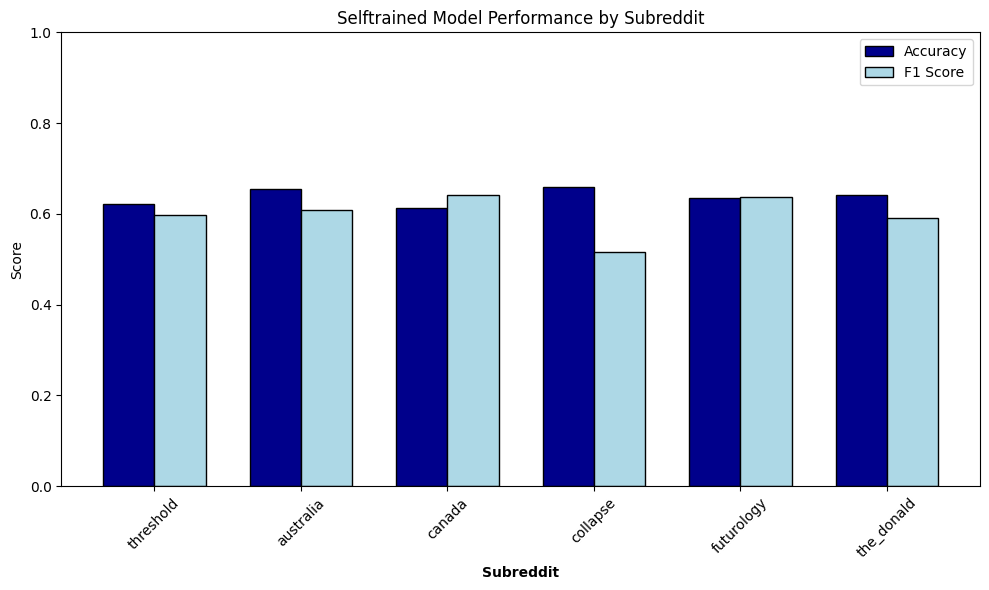

In [82]:
# Creating the plot for selftrained models
plt.figure(figsize=(10, 6))

plt.bar([p - bar_width/2 for p in positions], df['Selftrained Accuracy'], width=bar_width, color='darkblue', edgecolor='black', label='Accuracy')
plt.bar([p + bar_width/2 for p in positions], df['Selftrained F1'], width=bar_width, color='lightblue', edgecolor='black', label='F1 Score')

# Adding the Subreddit names as x-axis labels
plt.xlabel('Subreddit', fontweight='bold')
plt.xticks(positions, df['Subreddit'], rotation=45)

# Setting the y-axis label and limits
plt.ylabel('Score')
plt.ylim(0, 1)  # Setting y-axis to range from 0 to 1

# Adding a title
plt.title('Selftrained Model Performance by Subreddit')

# Adding a legend
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()

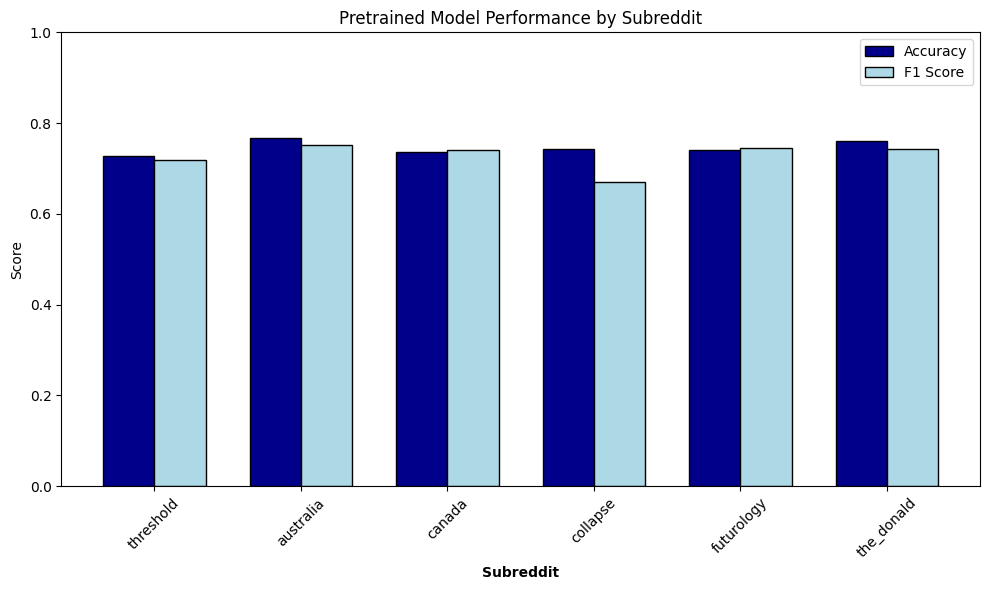

In [83]:
# Creating the plot for pretrained models
plt.figure(figsize=(10, 6))

plt.bar([p - bar_width/2 for p in positions], df['Pretrained Accuracy'], width=bar_width, color='darkblue', edgecolor='black', label='Accuracy')
plt.bar([p + bar_width/2 for p in positions], df['Pretrained F1'], width=bar_width, color='lightblue', edgecolor='black', label='F1 Score')

# Adding the Subreddit names as x-axis labels
plt.xlabel('Subreddit', fontweight='bold')
plt.xticks(positions, df['Subreddit'], rotation=45)

# Setting the y-axis label and limits
plt.ylabel('Score')
plt.ylim(0, 1)  # Setting y-axis to range from 0 to 1

# Adding a title
plt.title('Pretrained Model Performance by Subreddit')

# Adding a legend
plt.legend()

# Showing the plot
plt.tight_layout()
plt.show()